(bayes-workflow-notebook)=
# Credibilità, modelli e parametri 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


L'obiettivo di questo Capitolo è di introdurre il quadro concettuale dell'analisi dei dati bayesiana.

Le statistiche bayesiane sono un modo per stimare un parametro $\theta$ (cioè alcune quantità di interesse, come la media della popolazione, il coefficiente di regressione, ecc.) applicando il Teorema di Bayes:

\[
P(\theta|D) \propto P(D|\theta)P(\theta).
\]

Ci sono tre componenti nella formula precedente:

\begin{itemize}
    \item \(P(D|\theta)\), la probabilità di osservare i dati \(D\), dato il parametro \(\theta\); questa è chiamata verosimiglianza (Nota: È la verosimiglianza di \(\theta\), ma rappresenta la probabilità riguardo \(y\)).
    \item \(P(\theta)\), la distribuzione di probabilità di \(\theta\), senza riferirsi ai dati \(D\). Questo di solito richiede un ricorso al grado di credenza della persona, ed è quindi chiamato la probabilità a priori.
    \item \(P(\theta|y)\), la distribuzione di probabilità aggiornata di \(\theta\), dopo aver osservato i dati \(D\); questa è chiamata la probabilità a posteriori.
\end{itemize}

D'altra parte, le statistiche classiche/frequentiste si concentrano esclusivamente sulla funzione di verosimiglianza.


## Fondamenti dell'analisi dei dati bayesiana

La statistica bayesiana si basa su due idee fondamentali:

- La prima idea riguarda la distribuzione della credibilità tra le diverse ipotesi. Inizialmente, abbiamo delle conoscenze iniziali o "a priori" su quali ipotesi potrebbero essere plausibili. Successivamente, utilizzando i dati osservati, vogliamo aggiornare le nostre credenze in modo da ridistribuire la credibilità tra le diverse ipotesi, in base a quanto sono supportate dalle evidenze.
- La seconda idea è che le diverse ipotesi corrispondono ai possibili valori dei parametri di un modello statistico. In altre parole, stiamo cercando di inferire il valore dei parametri del modello che meglio descrivono il processo generativo dei dati che abbiamo osservato. In questo modo, vogliamo trovare il modello che meglio si adatta ai dati e che ci permette di fare previsioni precise.

## Un primo esempio

Esaminiamo un esempio proposto da Mark Lai. Al momento, ci concentriamo esclusivamente sui grafici e ignoriamo completamente il codice sorgente. L'obiettivo è comprendere cosa vogliamo ottenere. In seguito, affronteremo il problema di come realizzare questo obiettivo.

L'esempio riguarda la localizzazione di un aereo disperso in mare in un contesto semplificato. Supponiamo di sapere che l'aereo, prima di scomparire, stava volando su una latitudine specifica, dirigendosi verso ovest attraverso il Pacifico, e quindi dobbiamo solo determinare la sua longitudine. I soccorsi devono raccogliere i detriti (dati) per poter restringere la posizione ($\theta$) dell'aereo.

Per iniziare, consideriamo la nostra previsione iniziale, espressa tramite una distribuzione di probabilità approssimativa sulla posizione dell'aereo.

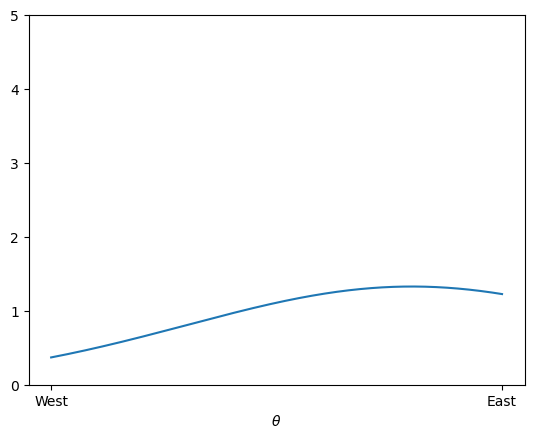

In [2]:
def dnorm_trunc(x, mean=0, sd=1, ll=0, ul=1):
    out = norm.pdf(x, mean, sd) / (norm.cdf(ul, mean, sd) - norm.cdf(ll, mean, sd))
    out[(x > ul) | (x < ll)] = 0
    return out

# Data points for x-axis
x_vals = np.linspace(0, 1, 1000)

# Parameters for the dnorm_trunc function
mean_val = 0.8
sd_val = 0.5

# Calculate the y values using dnorm_trunc function
y_vals = dnorm_trunc(x_vals, mean_val, sd_val)

# Plot the curve
plt.plot(x_vals, y_vals)
plt.ylim(0, 5)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([0, 1], ["West", "East"])
plt.show()

#hide


La nostra credenza a priori indica che riteniamo sia due volte più probabile che l'aereo si trovi ad est rispetto a ovest. Di seguito sono riportate altre due possibilità per le distribuzioni a priori (su infinite possibilità), una che fornisce praticamente nessuna informazione e l'altra che codifica informazioni più forti.

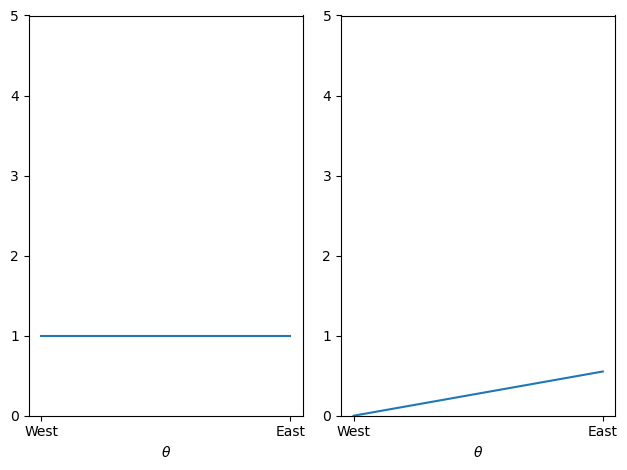

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

def dnorm_trunc(x, mean=0, sd=1, ll=0, ul=1):
    out = norm.pdf(x, mean, sd) / (norm.cdf(ul, mean, sd) - norm.cdf(ll, mean, sd))
    out[(x > ul) | (x < ll)] = 0
    return out

# Data points for x-axis
x_vals = np.array([0, 1])

# Plot p1
plt.subplot(1, 2, 1)
plt.plot(x_vals, uniform.pdf(x_vals))
plt.ylim(0, 5)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([0, 1], ["West", "East"])

# Plot p3
plt.subplot(1, 2, 2)
plt.plot(x_vals, dnorm_trunc(x_vals, mean=0.8, sd=0.1))
plt.ylim(0, 5)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([0, 1], ["West", "East"])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#hide


La distribuzione a priori viene scelta per esprimere la convinzione del ricercatore riguardo al problema in esame. Di conseguenza, diversi ricercatori potrebbero formulare distribuzioni a priori diverse per lo stesso problema, e ciò è del tutto accettabile, purché tali distribuzioni a priori siano ragionevoli e giustificate. Successivamente, scopriremo che nelle analisi Bayesiane, anche con campioni di dimensioni moderate, le diverse distribuzioni a priori generalmente producono solo differenze trascurabili.

Ora, supponiamo di aver raccolto dei detriti nelle posizioni mostrate nel grafico seguente.

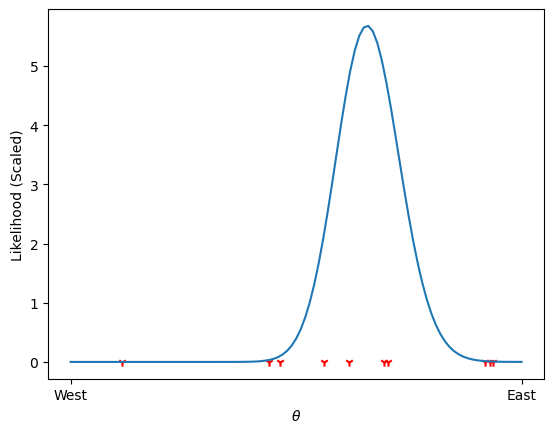

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

def qnorm_trunc(p, mean=0, sd=1, ll=0, ul=1):
    cdf_ll = norm.cdf(ll, loc=mean, scale=sd)
    cdf_ul = norm.cdf(ul, loc=mean, scale=sd)
    return norm.ppf(cdf_ll + p * (cdf_ul - cdf_ll), loc=mean, scale=sd)

def rnorm_trunc(n, mean=0, sd=1, ll=0, ul=1):
    p = np.random.uniform(size=n)
    return qnorm_trunc(p, mean=mean, sd=sd, ll=ll, ul=ul)

grid = np.linspace(0, 1, num=101)

def compute_lik(x, pts=grid, sd=0.2, binwidth=0.01):
    lik_vals = norm.pdf(x[:, np.newaxis], loc=pts, scale=sd) / (norm.cdf(1, loc=pts, scale=sd) - norm.cdf(0, loc=pts, scale=sd))
    lik = np.prod(lik_vals, axis=0)
    return lik / np.sum(lik) / binwidth

np.random.seed(4)
dat_x = rnorm_trunc(10, mean=0.6, sd=0.2)
lik_x = compute_lik(dat_x)

plt.plot(grid, lik_x)
plt.scatter(dat_x, np.zeros_like(dat_x), color='red', marker='1')
plt.xlabel(r'$\theta$')
plt.ylabel('Likelihood (Scaled)')
plt.xticks([0, 1], ["West", "East"])
plt.show()

#hide

Dal Teorema di Bayes possiamo derivare la distribuzione a posteriori nel modo seguente:

$$
\text{Probabilità Posteriore} \propto \text{Probabilità a Priori} \times
                                       \text{Verosimiglianza}.
$$

In altre parole, possiamo semplicemente moltiplicare le probabilità a priori e la verosimiglianza per ottenere la probabilità posteriore per ogni posizione. È necessario anche garantire che l'area sotto la curva sia pari a 1, ma questo di solito viene eseguito da un software.

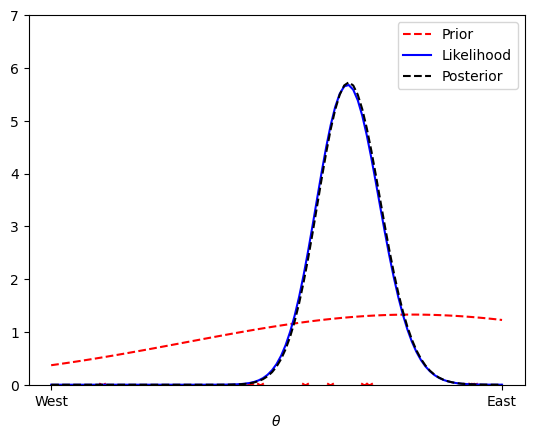

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def dnorm_trunc(x, mean=0, sd=1, ll=0, ul=1):
    out = norm.pdf(x, mean, sd) / (norm.cdf(ul, mean, sd) - norm.cdf(ll, mean, sd))
    out[(x > ul) | (x < ll)] = 0
    return out

def update_probs(prior_probs, lik, binwidth=0.01):
    post_probs = prior_probs * lik
    return post_probs / np.sum(post_probs) / binwidth

grid = np.linspace(0, 1, num=101)

# Prior probabilities
prior_probs = dnorm_trunc(grid, mean=0.8, sd=0.5)

# Likelihood values
lik_x = compute_lik(dat_x)

# Posterior probabilities
posterior_probs = update_probs(prior_probs, lik_x)

# Plotting
plt.plot(grid, dnorm_trunc(grid, mean=0.8, sd=0.5), linestyle='dashed', color='red', label='Prior')
plt.plot(grid, lik_x, linestyle='solid', color='blue', label='Likelihood')
plt.plot(grid, posterior_probs, linestyle='dashed', color='black', label='Posterior')
plt.scatter(dat_x, np.zeros_like(dat_x), color='red', marker='1')
plt.ylim(0, 7)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([0, 1], ["West", "East"])
plt.legend()
plt.show()


In questo caso vediamo che una distribuzione a priori debolmente informativa praticamente non ha alcun effetto e la distribuzione a posteriori è quasi identica alla verosimiglianza (normalizzata).

Di seguito viene mostrato cosa accade con una distribuzione a priori più forte.

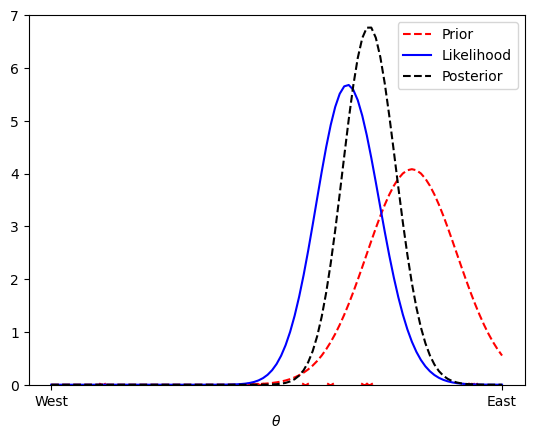

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

def dnorm_trunc(x, mean=0, sd=1, ll=0, ul=1):
    out = norm.pdf(x, mean, sd) / (norm.cdf(ul, mean, sd) - norm.cdf(ll, mean, sd))
    out[(x > ul) | (x < ll)] = 0
    return out

def update_probs(prior_probs, lik, binwidth=0.01):
    post_probs = prior_probs * lik
    return post_probs / np.sum(post_probs) / binwidth

grid = np.linspace(0, 1, num=101)

# Prior probabilities
prior_probs = dnorm_trunc(grid, mean=0.8, sd=0.1)

# Likelihood values
lik_x = compute_lik(dat_x)

# Posterior probabilities
posterior_probs = update_probs(prior_probs, lik_x)

# Plotting
plt.plot(grid, dnorm_trunc(grid, mean=0.8, sd=0.1), linestyle='dashed', color='red', label='Prior')
plt.plot(grid, lik_x, linestyle='solid', color='blue', label='Likelihood')
plt.plot(grid, posterior_probs, linestyle='dashed', color='black', label='Posterior')
plt.scatter(dat_x, np.zeros_like(dat_x), color='red', marker='1')
plt.ylim(0, 7)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([0, 1], ["West", "East"])
plt.legend()
plt.show()

## Modellizzazione bayesiana

La moderna statistica bayesiana si basa principalmente sull'uso di un linguaggio di programmazione probabilistico implementato su computer, il che ha rivoluzionato il modo in cui venivano eseguite le statistiche bayesiane anche solo pochi decenni fa. L'utilizzo di questi metodi computazionali ha reso più facile la formulazione di modelli statistici complessi, riducendo la barriera delle competenze matematiche e computazionali richieste, e ha semplificato il processo di modellazione iterativa. 

Nell'approccio bayesiano all'inferenza statistica, si assume l'esistenza di una variabile casuale $Y$ di cui si conosce la distribuzione a meno di un parametro (o più parametri) $\theta$. Secondo l'approccio bayesiano, si rappresenta l'incertezza sul valore del parametro ignoto $\mu$ con una variabile casuale continua $\Theta$, che ha come supporto l'insieme dei valori ammissibili per il parametro. La funzione di densità di probabilità $p(\theta)$, chiamata distribuzione a priori, rappresenta la sintesi delle opinioni e delle informazioni che si hanno sul parametro prima dell'osservazione dei dati. 

L'aggiornamento dell'incertezza su $\theta$ avviene con l'osservazione dei risultati di un esperimento casuale, ovvero dall'evidenza $y$ proveniente da un campione osservato di dimensione $n$. Le informazioni provenienti dal campione osservato $y = (y_1, \dots, y_n)$ sono contenute nella funzione di verosimiglianza $p(y \mid \theta)$, che rappresenta la probabilità di osservare i dati del campione dato il valore del parametro $\theta$. 

Dopo aver osservato l'evidenza empirica $y$, l'aggiornamento delle conoscenze a priori contenute nella distribuzione iniziale $p(\theta)$ avviene utilizzando il teorema di Bayes. La distribuzione a posteriori $p(\theta \mid y)$ è proporzionale al prodotto della probabilità a priori e della verosimiglianza:

$$
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{\int_{\Theta}p(y \mid \theta) p(\theta) \,\operatorname {d}\!\theta} \quad \theta \in \Theta.
$$(eq-bayes-intro)

In sintesi, la distribuzione a posteriori del parametro $\mu$ rappresenta la credibilità che possiamo attribuire ai vari valori possibili del parametro $\theta$ sulla base dei dati disponibili, insieme alle nostre conoscenze pregresse.

## Notazione

Per fissare la notazione, nel seguito $y$ rappresenterà i dati e $\theta$ rappresenterà i parametri incogniti di un modello statistico. Sia $y$ che $\theta$ vengono concepiti come variabili casuali. Con $x$ vengono invece denotate le quantità note, come ad esempio i predittori del modello lineare. Per rappresentare in un modo conciso i modelli probabilistici viene usata una notazione particolare. Ad esempio, invece di scrivere $p(\theta) = Beta(1, 1)$ scriviamo $\theta \sim Beta(1, 1)$. Il simbolo "$\sim$" viene spesso letto "è distribuito come". Possiamo anche pensare che significhi che $\theta$ costituisce un campione casuale estratto dalla distribuzione Beta(1, 1). Allo stesso modo, ad esempio, la verosimiglianza del modello binomiale può essere scritta come $y \sim \text{Bin}(n, \theta)$.

## Distribuzioni a priori

In un approccio bayesiano, i parametri della distribuzione di riferimento non sono considerati costanti incognite, ma piuttosto variabili casuali, e perciò sono descritti da una distribuzione di probabilità a priori. La scelta della distribuzione a priori dipende dalle informazioni disponibili e si cerca di assegnare una probabilità maggiore ai valori del parametro che sono considerati più plausibili. Idealmente, le credenze a priori che portano alla scelta della distribuzione a priori dovrebbero essere supportate da una qualche motivazione, come ad esempio i risultati di ricerche precedenti.

### Tipologie di distribuzioni a priori

Possiamo distinguere tra diverse distribuzioni a priori in base a quanto fortemente impegnano il ricercatore a ritenere come credibile un particolare intervallo di valori dei parametri. Un caso estremo è quello che rivela una totale assenza di conoscenze a priori, il che conduce alle *distribuzioni a priori non informative*, ovvero quelle che assegnano lo stesso livello di credibilità a tutti i valori dei parametri. Le distribuzioni a priori informative, d'altra parte, possono essere *debolmente informative* o *fortemente informative*, a seconda del modo in cui lo sperimentatore distribuisce la credibilità nello spazio del parametro. Un caso estremo di credenza a priori è quello che assegna tutta la credibilità ad un singolo valore del parametro. La figura seguente mostra alcuni esempi di distribuzioni a priori per il modello Binomiale:

-   distribuzione *non informativa*: $\theta_c \sim Beta(1,1)$;
-   distribuzione *debolmente informativa*: $\theta_c \sim Beta(5,2)$;
-   distribuzione *fortemente informativa*: $\theta_c \sim Beta(50,20)$;
-   *valore puntuale*: $\theta_c \sim Beta(\alpha, \beta)$ con $\alpha, \beta \rightarrow \infty$ e $\frac{\alpha}{\beta} = \frac{5}{2}$.

![](images/intro_bayes_4.png)

## La funzione di verosimiglianza

La funzione di verosimiglianza per due casi tipici, quello binomiale e quello Normale, è stata descritta nel capitolo {ref}`cap-likelihood`.

## La verosimiglianza marginale

Per il calcolo di $p(\theta \mid y)$ è necessario dividere il prodotto tra la distribuzione a priori e la verosimiglianza per una costante di normalizzazione. Tale costante di normalizzazione, detta *verosimiglianza marginale*, ha lo scopo di fare in modo che $p(\theta \mid y)$ abbia area unitaria.

Si noti che la verosimiglianza marginale (ovvero, l'integrale al denominatore della eq. {eq}`eq-bayes-intro` è spesso di difficile risoluzione analitica per cui l'inferenza bayesiana solitamente procede attraverso metodi di ricampionamento e metodi iterativi, quali le Catene di Markov Monte Carlo (MCMC).

## La distribuzione a posteriori

La distribuzione a postreriori si trova applicando il teorema di Bayes:

$$
\text{probabilità a posteriori} = \frac{\text{probabilità a priori} \cdot \text{verosimiglianza}}{\text{costante di normalizzazione}}
$$

Nei Capitoli successivi vedremo come calcolare la distribuzione a posteriori. Ci sono due metodi:

-   un metodo esatto, che può essere usato nel caso delle distribuzioni a priori coniugate;
-   un metodo approssimato, che può sempre essere usato, ma è computazionalmente intensivo.


## Distribuzione predittiva a priori

La distribuzione a posteriori è l'oggetto centrale nella statistica bayesiana, ma non è l'unico. Oltre a fare inferenze sui valori dei parametri, potremmo voler fare inferenza sui dati. Questo può essere fatto calcolando la *distribuzione predittiva a priori*:

$$
p(y^*) = \int_\Theta p(y^* \mid \theta) p(\theta) \,\operatorname {d}\!\theta .
$$ (eq-prior-pred-distr)

La {eq}`eq-prior-pred-distr` descrive la distribuzione prevista dei dati in base al modello (che include la distribuzione a priori e la verosimiglianza), ovvero descrive i dati $y^*$ che ci aspettiamo di osservare, dato il modello, prima di avere osservato i dati del campione. 

La distribuzione predittiva a priori è una distribuzione di (densità) di probabilità. È possibile utilizzare campioni dalla distribuzione predittiva a priori per valutare e calibrare i modelli utilizzando le nostre conoscenze dominio-specifiche. Ad esempio, ci possiamo chiedere: "È sensato che un modello dell'altezza umana preveda che un essere umano sia alto -1.5 metri?". Già prima di misurare una singola persona, possiamo renderci conto dell'assurdità di questa domanda. Se la distribuzione prevista dei dati consente domande di questo tipo (ovvero, prevede di osservare dati che risultano insensati alla luce delle nostre conoscenze dominio-specifiche), è chiaro che il modello deve essere riformulato.

## Commenti e considerazioni finali 

Secondo l'approccio bayesiano, anziché considerare il parametro di interesse di un modello statistico come un valore vero ma sconosciuto, si assegna prima dell'esperimento una distribuzione di probabilità, chiamata stato di credenza, al vero valore del parametro. Questa distribuzione a priori può essere conosciuta, come nel caso della distribuzione normale con media 100 e deviazione standard 15 per i punteggi del QI, oppure può essere arbitraria. Successivamente, si raccolgono dei dati e si calcola la probabilità dei possibili valori del parametro in base ai dati osservati e alle credenze a priori. La nuova distribuzione di probabilità ottenuta è chiamata "distribuzione a posteriori" e rappresenta l'incertezza dell'inferenza. Questo Capitolo ha brevemente descritto i concetti fondamentali dell'inferenza statistica bayesiana.